## Part 1: Matrix Multiplication on the CPU

### Step 1.1: Write a C Program for Matrix Multiplication

### You need to implement a program that does a matrix multiplication in C

In [1]:
# import statements
import subprocess
import re
import ctypes
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

In [2]:
%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrixMultiplyCPU(float *A, float *B, float *C, int N)
{
  for (int i = 0; i<N; i++){
    for (int j=0; j<N;j++){
      float sum = 0.0f;
      int A_ind = 0, B_ind = 0, C_ind = 0;
      for (int k = 0; k < N; k++){
        A_ind = i*N + k;
        B_ind = k*N + j;
        sum += A[A_ind] * B[B_ind];
      }
      C_ind = i*N + j;
      C[C_ind] = sum;
    }
  }
}

int main(int argc, char **argv){
  int N = (argc > 1) ? atoi(argv[1]) : 1024;

  size_t size = N * N * sizeof(float);

  float *A = (float *)malloc(size);
  float *B = (float *)malloc(size);
  float *C = (float *)malloc(size);

  for (int i = 0; i<N*N; i++){
    A[i] = (float)(rand() % 100) / 100.0f;
    B[i] = (float)(rand() % 100) / 100.0f;
  }

  clock_t start = clock();
  matrixMultiplyCPU(A, B, C, N);
  clock_t end = clock();

  double elapsed = (double)(end - start) / CLOCKS_PER_SEC;
  printf("CPU execution time (N=%d): %.6f seconds\n", N, elapsed);

  free(A);
  free(B);
  free(C);

  return 0;

}

Writing matrix_cpu.c


In [3]:
!gcc matrix_cpu.c -o matrix_cpu -O2

In [4]:
# Matrix sizes to test
sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]

cpu_results = {}

for N in sizes:
    print(f"Running N={N}...")
    # Run the compiled C program and capture output
    output = subprocess.check_output(["./matrix_cpu", str(N)], text=True)
    print(output)

    # Extract the time using regex
    match = re.search(r"([0-9]+\.[0-9]+) seconds", output)
    if match:
        time_sec = float(match.group(1))
        cpu_results[N] = time_sec

cpu_results

Running N=256...
CPU execution time (N=256): 0.025421 seconds

Running N=512...
CPU execution time (N=512): 0.380715 seconds

Running N=768...
CPU execution time (N=768): 1.107515 seconds

Running N=1024...
CPU execution time (N=1024): 3.943428 seconds

Running N=1536...
CPU execution time (N=1536): 15.728022 seconds

Running N=2048...
CPU execution time (N=2048): 75.972048 seconds

Running N=3072...
CPU execution time (N=3072): 274.939677 seconds

Running N=4096...
CPU execution time (N=4096): 759.065015 seconds



{256: 0.025421,
 512: 0.380715,
 768: 1.107515,
 1024: 3.943428,
 1536: 15.728022,
 2048: 75.972048,
 3072: 274.939677,
 4096: 759.065015}

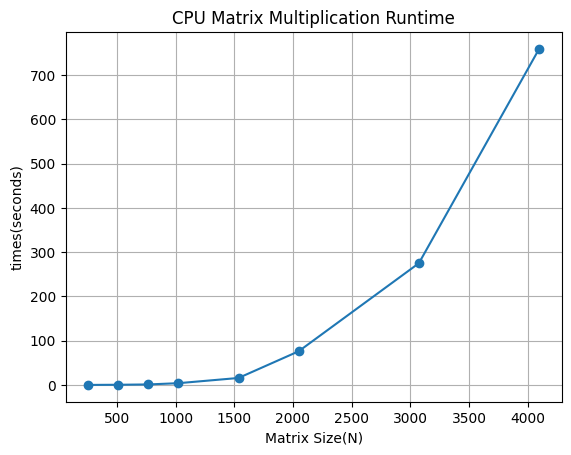

In [5]:
Ns = list(cpu_results.keys())
times = list(cpu_results.values())
X = Ns
Y = times
plt.plot(X, Y, marker = 'o')
plt.xlabel("Matrix Size(N)")
plt.ylabel("times(seconds)")
plt.title("CPU Matrix Multiplication Runtime")
plt.grid(True)
plt.show()


In [6]:
df = pd.DataFrame({
    "Matrix Size (N)": Ns,
    "CPU Time (seconds)": times
})

df

,Matrix Size (N),CPU Time (seconds)
0,256,0.025421
1,512,0.380715
2,768,1.107515
3,1024,3.943428
4,1536,15.728022
5,2048,75.972048
6,3072,274.939677
7,4096,759.065015


### Part 2: Introduction to CUDA Programming  and Part 3: Running CUDA on Google Cloud

Step 2.1: Naïve CUDA Kernel

Implement a CUDA kernel where each thread computes one element of the output matrix.

Run the CUDA program with multiple matrix sizes (512, 1024, 2048, etc.) and measure
execution time as you did in Part 1. If you have an Nvidia GPU that supports CUDA on your
computer.

In [7]:
# Verify GPU in Colab
!nvidia-smi

Sat Jan 31 23:43:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
%%writefile matrix_gpu.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplyGPU(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // *** FIXED BLOCK SIZE ***
    dim3 block(8, 8);
    dim3 grid((N + block.x - 1) / block.x,
              (N + block.y - 1) / block.y);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    matrixMultiplyGPU<<<grid, block>>>(d_A, d_B, d_C, N);

    // Check for kernel launch errors
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA ERROR: %s\n", cudaGetErrorString(err));
        return 1;
    }

    cudaDeviceSynchronize();
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    printf("Naive CUDA execution time (N=%d): %.4f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    free(h_A);
    free(h_B);
    free(h_C);

    return 0;
}

Writing matrix_gpu.cu


In [9]:
!nvcc -O3 -arch=sm_75 matrix_gpu.cu -o matrix_gpu

In [10]:
sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]
gpu_results = {}

for N in sizes:
    print(f"\nRunning N={N}...")
    result = subprocess.run(
        ["./matrix_gpu", str(N)],
        text=True,
        capture_output=True
    )

    print("STDOUT:")
    print(result.stdout)

    print("STDERR:")
    print(result.stderr)

    if result.returncode != 0:
        print(f"Program exited with code {result.returncode}")
        continue

    match = re.search(r"([0-9]+\.[0-9]+) ms", result.stdout)
    if match:
        gpu_results[N] = float(match.group(1))

gpu_results


Running N=256...
STDOUT:
Naive CUDA execution time (N=256): 0.3881 ms

STDERR:


Running N=512...
STDOUT:
Naive CUDA execution time (N=512): 1.8871 ms

STDERR:


Running N=768...
STDOUT:
Naive CUDA execution time (N=768): 6.2593 ms

STDERR:


Running N=1024...
STDOUT:
Naive CUDA execution time (N=1024): 14.4605 ms

STDERR:


Running N=1536...
STDOUT:
Naive CUDA execution time (N=1536): 49.3840 ms

STDERR:


Running N=2048...
STDOUT:
Naive CUDA execution time (N=2048): 115.0608 ms

STDERR:


Running N=3072...
STDOUT:
Naive CUDA execution time (N=3072): 289.4743 ms

STDERR:


Running N=4096...
STDOUT:
Naive CUDA execution time (N=4096): 453.5350 ms

STDERR:



{256: 0.3881,
 512: 1.8871,
 768: 6.2593,
 1024: 14.4605,
 1536: 49.384,
 2048: 115.0608,
 3072: 289.4743,
 4096: 453.535}

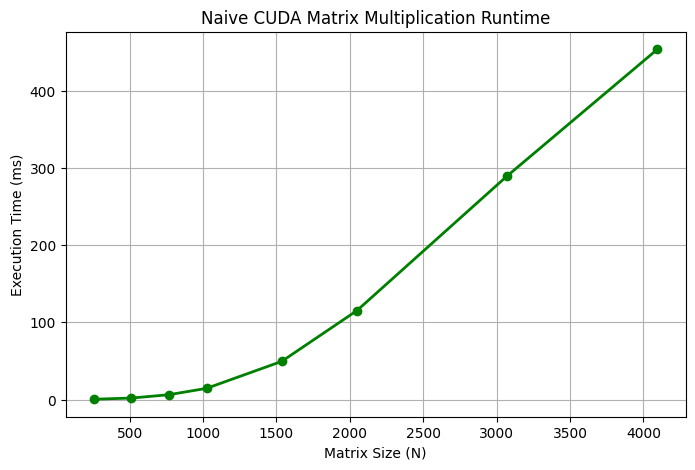

In [11]:
Ns = list(gpu_results.keys())
times = list(gpu_results.values())

plt.figure(figsize=(8,5))
plt.plot(Ns, times, marker='o', linewidth=2, color='green')
plt.xlabel("Matrix Size (N)")
plt.ylabel("Execution Time (ms)")
plt.title("Naive CUDA Matrix Multiplication Runtime")
plt.grid(True)
plt.show()

In [12]:
df = pd.DataFrame({
    "N": Ns,
    "GPU Time (ms)": times
})

df

,N,GPU Time (ms)
0,256,0.3881
1,512,1.8871
2,768,6.2593
3,1024,14.4605
4,1536,49.3840
5,2048,115.0608
6,3072,289.4743
7,4096,453.5350


## Part 4: Optimizing CUDA Code

### Step 4.1: Shared Memory Tiling

In [13]:
%%writefile matrix_gpu_tiled.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define TILE_SIZE 16

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) {
    __shared__ float As[TILE_SIZE][TILE_SIZE];
    __shared__ float Bs[TILE_SIZE][TILE_SIZE];

    int row = blockIdx.y * TILE_SIZE + threadIdx.y;
    int col = blockIdx.x * TILE_SIZE + threadIdx.x;

    float sum = 0.0f;

    int numTiles = (N + TILE_SIZE - 1) / TILE_SIZE;

    for (int t = 0; t < numTiles; t++) {
        int tiledColA = t * TILE_SIZE + threadIdx.x;
        int tiledRowB = t * TILE_SIZE + threadIdx.y;

        // Load A tile
        if (row < N && tiledColA < N)
            As[threadIdx.y][threadIdx.x] = A[row * N + tiledColA];
        else
            As[threadIdx.y][threadIdx.x] = 0.0f;

        // Load B tile
        if (tiledRowB < N && col < N)
            Bs[threadIdx.y][threadIdx.x] = B[tiledRowB * N + col];
        else
            Bs[threadIdx.y][threadIdx.x] = 0.0f;

        __syncthreads();

        for (int k = 0; k < TILE_SIZE; k++)
            sum += As[threadIdx.y][k] * Bs[k][threadIdx.x];

        __syncthreads();
    }

    if (row < N && col < N)
        C[row * N + col] = sum;
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 block(TILE_SIZE, TILE_SIZE);
    dim3 grid((N + TILE_SIZE - 1) / TILE_SIZE,
              (N + TILE_SIZE - 1) / TILE_SIZE);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA ERROR: %s\n", cudaGetErrorString(err));
        return 1;
    }

    cudaDeviceSynchronize();
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    printf("Tiled CUDA execution time (N=%d): %.4f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    free(h_A);
    free(h_B);
    free(h_C);

    return 0;
}

Writing matrix_gpu_tiled.cu


In [14]:
!nvcc -O3 -arch=sm_75 matrix_gpu_tiled.cu -o matrix_gpu_tiled

In [15]:
sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]
tiled_results = {}

for N in sizes:
    print(f"Running tiled N={N}...")
    output = subprocess.check_output(["./matrix_gpu_tiled", str(N)], text=True)
    print(output)

    match = re.search(r"([0-9]+\.[0-9]+) ms", output)
    if match:
        time_ms = float(match.group(1))
        tiled_results[N] = time_ms

tiled_results

Running tiled N=256...
Tiled CUDA execution time (N=256): 0.1884 ms

Running tiled N=512...
Tiled CUDA execution time (N=512): 0.8266 ms

Running tiled N=768...
Tiled CUDA execution time (N=768): 2.5648 ms

Running tiled N=1024...
Tiled CUDA execution time (N=1024): 5.8692 ms

Running tiled N=1536...
Tiled CUDA execution time (N=1536): 19.6092 ms

Running tiled N=2048...
Tiled CUDA execution time (N=2048): 46.3765 ms

Running tiled N=3072...
Tiled CUDA execution time (N=3072): 155.7375 ms

Running tiled N=4096...
Tiled CUDA execution time (N=4096): 224.8104 ms



{256: 0.1884,
 512: 0.8266,
 768: 2.5648,
 1024: 5.8692,
 1536: 19.6092,
 2048: 46.3765,
 3072: 155.7375,
 4096: 224.8104}

In [16]:
Ns = sorted(tiled_results.keys())

df = pd.DataFrame({
    "N": Ns,
    "CPU Time (s)": [cpu_results[n] for n in Ns],
    "Naive GPU (ms)": [gpu_results[n] for n in Ns],
    "Tiled GPU (ms)": [tiled_results[n] for n in Ns],
})

df

,N,CPU Time (s),Naive GPU (ms),Tiled GPU (ms)
0,256,0.025421,0.3881,0.1884
1,512,0.380715,1.8871,0.8266
2,768,1.107515,6.2593,2.5648
3,1024,3.943428,14.4605,5.8692
4,1536,15.728022,49.3840,19.6092
5,2048,75.972048,115.0608,46.3765
6,3072,274.939677,289.4743,155.7375
7,4096,759.065015,453.5350,224.8104


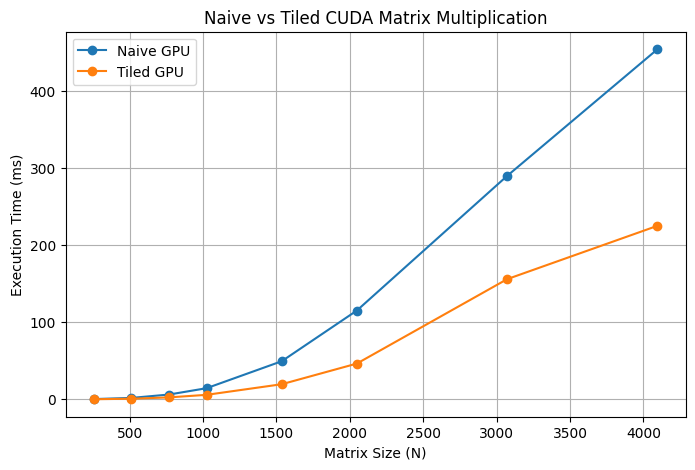

In [17]:
plt.figure(figsize=(8,5))
plt.plot(Ns, [gpu_results[n] for n in Ns], marker='o', label='Naive GPU')
plt.plot(Ns, [tiled_results[n] for n in Ns], marker='o', label='Tiled GPU')
plt.xlabel("Matrix Size (N)")
plt.ylabel("Execution Time (ms)")
plt.title("Naive vs Tiled CUDA Matrix Multiplication")
plt.grid(True)
plt.legend()
plt.show()

## Part 5: Performance Comparison

In [18]:
import pandas as pd

# Use the Ns list you already defined
# Ns = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]

# Convert GPU ms → seconds for speedup calculation
naive_sec = {n: gpu_results[n] / 1000 for n in Ns}
tiled_sec = {n: tiled_results[n] / 1000 for n in Ns}
#cublas_sec = {n: cublas_results[n] / 1000 for n in Ns}

# Compute speedups
speedup_naive = {n: cpu_results[n] / naive_sec[n] for n in Ns}
speedup_tiled = {n: cpu_results[n] / tiled_sec[n] for n in Ns}
#speedup_cublas = {n: cpu_results[n] / cublas_sec[n] for n in Ns}

# Build DataFrame automatically
df = pd.DataFrame({
    "N": Ns,
    "CPU Time (s)": [cpu_results[n] for n in Ns],
    "Naive GPU (ms)": [gpu_results[n] for n in Ns],
    "Tiled GPU (ms)": [tiled_results[n] for n in Ns],
    "Speedup CPU/Naive": [speedup_naive[n] for n in Ns],
    "Speedup CPU/Tiled": [speedup_tiled[n] for n in Ns],
})

df

,N,CPU Time (s),Naive GPU (ms),Tiled GPU (ms),Speedup CPU/Naive,Speedup CPU/Tiled
0,256,0.025421,0.3881,0.1884,65.501159,134.930998
1,512,0.380715,1.8871,0.8266,201.746065,460.579482
2,768,1.107515,6.2593,2.5648,176.939115,431.813397
3,1024,3.943428,14.4605,5.8692,272.703433,671.885095
4,1536,15.728022,49.3840,19.6092,318.484165,802.073619
5,2048,75.972048,115.0608,46.3765,660.277419,1638.158291
6,3072,274.939677,289.4743,155.7375,949.789591,1765.404459
7,4096,759.065015,453.5350,224.8104,1673.663587,3376.467526


## Part 6: Using cuBLAS Library

Use cuBLAS (already included with CUDA Toolkit) to perform matrix multiplication.

In [19]:
%%writefile matrix_cublas.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <cublas_v2.h>

int main(int argc, char **argv){
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = N * N * sizeof(float);

    float *h_A = (float*)malloc(size);
    float *h_B = (float*)malloc(size);
    float *h_C = (float*)malloc(size);

    for (int i = 0; i < N*N; i++){
        h_A[i] = (float)(rand()%100) / 100.0f;
        h_B[i] = (float)(rand()%100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    cublasHandle_t handle;
    cublasCreate(&handle);

    float alpha = 1.0f, beta = 0.0f;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    cublasStatus_t stat = cublasSgemm(
        handle,
        CUBLAS_OP_N, CUBLAS_OP_N,
        N, N, N,
        &alpha,
        d_B, N,
        d_A, N,
        &beta,
        d_C, N
    );

    if (stat != CUBLAS_STATUS_SUCCESS) {
        printf("cuBLAS ERROR: %d\n", stat);
        return 1;
    }

    cudaDeviceSynchronize();   // IMPORTANT

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    printf("cuBLAS execution time (N=%d): %.4f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    cublasDestroy(handle);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    free(h_A);
    free(h_B);
    free(h_C);

    return 0;
}

Writing matrix_cublas.cu


In [20]:
!nvcc -O3 -arch=sm_75 matrix_cublas.cu -lcublas -o matrix_cublas

In [21]:
sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]
cublas_results = {}

for N in sizes:
    print(f"Running cuBLAS N={N}...")
    output = subprocess.check_output(["./matrix_cublas", str(N)], text=True)
    print(output)

    match = re.search(r"([0-9]+\.[0-9]+) ms", output)
    if match:
        cublas_results[N] = float(match.group(1))

cublas_results

Running cuBLAS N=256...
cuBLAS execution time (N=256): 94.3694 ms

Running cuBLAS N=512...
cuBLAS execution time (N=512): 6.0694 ms

Running cuBLAS N=768...
cuBLAS execution time (N=768): 6.1716 ms

Running cuBLAS N=1024...
cuBLAS execution time (N=1024): 6.6140 ms

Running cuBLAS N=1536...
cuBLAS execution time (N=1536): 8.2294 ms

Running cuBLAS N=2048...
cuBLAS execution time (N=2048): 11.9126 ms

Running cuBLAS N=3072...
cuBLAS execution time (N=3072): 25.5814 ms

Running cuBLAS N=4096...
cuBLAS execution time (N=4096): 53.1316 ms



{256: 94.3694,
 512: 6.0694,
 768: 6.1716,
 1024: 6.614,
 1536: 8.2294,
 2048: 11.9126,
 3072: 25.5814,
 4096: 53.1316}

In [22]:
sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]
cublas_results = {}

for N in sizes:
    print(f"Running cuBLAS N={N}...")
    output = subprocess.check_output(["./matrix_cublas", str(N)], text=True)
    print(output)

    match = re.search(r"([0-9]+\.[0-9]+) ms", output)
    if match:
        cublas_results[N] = float(match.group(1))

cublas_results

Running cuBLAS N=256...
cuBLAS execution time (N=256): 11.1144 ms

Running cuBLAS N=512...
cuBLAS execution time (N=512): 6.0198 ms

Running cuBLAS N=768...
cuBLAS execution time (N=768): 7.7849 ms

Running cuBLAS N=1024...
cuBLAS execution time (N=1024): 8.3791 ms

Running cuBLAS N=1536...
cuBLAS execution time (N=1536): 9.9385 ms

Running cuBLAS N=2048...
cuBLAS execution time (N=2048): 13.6646 ms

Running cuBLAS N=3072...
cuBLAS execution time (N=3072): 25.8882 ms

Running cuBLAS N=4096...
cuBLAS execution time (N=4096): 53.2348 ms



{256: 11.1144,
 512: 6.0198,
 768: 7.7849,
 1024: 8.3791,
 1536: 9.9385,
 2048: 13.6646,
 3072: 25.8882,
 4096: 53.2348}

In [23]:
df = pd.DataFrame({
    "N": sizes,
    "CPU (s)": [cpu_results[n] for n in sizes],
    "Naive CUDA (ms)": [gpu_results[n] for n in sizes],
    "Tiled CUDA (ms)": [tiled_results[n] for n in sizes],
    "cuBLAS (ms)": [cublas_results[n] for n in sizes]
})

df

,N,CPU (s),Naive CUDA (ms),Tiled CUDA (ms),cuBLAS (ms)
0,256,0.025421,0.3881,0.1884,11.1144
1,512,0.380715,1.8871,0.8266,6.0198
2,768,1.107515,6.2593,2.5648,7.7849
3,1024,3.943428,14.4605,5.8692,8.3791
4,1536,15.728022,49.3840,19.6092,9.9385
5,2048,75.972048,115.0608,46.3765,13.6646
6,3072,274.939677,289.4743,155.7375,25.8882
7,4096,759.065015,453.5350,224.8104,53.2348


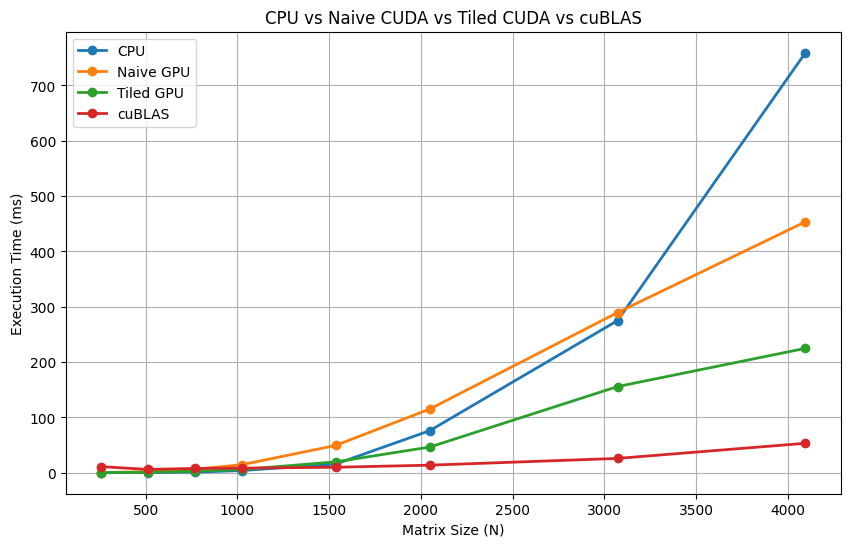

In [24]:
plt.figure(figsize=(10,6))

# Plot CPU
plt.plot(Ns, [cpu_results[n] for n in Ns], marker='o', label='CPU', linewidth=2)

# Plot Naive GPU
plt.plot(Ns, [gpu_results[n] for n in Ns], marker='o', label='Naive GPU', linewidth=2)

# Plot Tiled GPU
plt.plot(Ns, [tiled_results[n] for n in Ns], marker='o', label='Tiled GPU', linewidth=2)

# Plot cuBLAS
plt.plot(Ns, [cublas_results[n] for n in Ns], marker='o', label='cuBLAS', linewidth=2)

plt.xlabel("Matrix Size (N)")
plt.ylabel("Execution Time (ms)")
plt.title("CPU vs Naive CUDA vs Tiled CUDA vs cuBLAS")
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Use the Ns list already defined
# Ns = [256, 512, 768, 1024, 1536, 2048, 3072, 4096]

# Convert GPU ms → seconds for speedup calculation
naive_sec = {n: gpu_results[n] / 1000 for n in Ns}
tiled_sec = {n: tiled_results[n] / 1000 for n in Ns}
cublas_sec = {n: cublas_results[n] / 1000 for n in Ns}

# Compute speedups
speedup_naive = {n: cpu_results[n] / naive_sec[n] for n in Ns}
speedup_tiled = {n: cpu_results[n] / tiled_sec[n] for n in Ns}
speedup_cublas = {n: cpu_results[n] / cublas_sec[n] for n in Ns}

# Build DataFrame automatically
df = pd.DataFrame({
    "N": Ns,
    "CPU Time (s)": [cpu_results[n] for n in Ns],
    "Naive GPU (ms)": [gpu_results[n] for n in Ns],
    "Tiled GPU (ms)": [tiled_results[n] for n in Ns],
    "cuBLAS (ms)": [cublas_results[n] for n in Ns],
    "Speedup CPU/Naive": [speedup_naive[n] for n in Ns],
    "Speedup CPU/Tiled": [speedup_tiled[n] for n in Ns],
    "Speedup CPU/cuBLAS": [speedup_cublas[n] for n in Ns],
})

df

,N,CPU Time (s),Naive GPU (ms),Tiled GPU (ms),cuBLAS (ms),Speedup CPU/Naive,Speedup CPU/Tiled,Speedup CPU/cuBLAS
0,256,0.025421,0.3881,0.1884,11.1144,65.501159,134.930998,2.287213
1,512,0.380715,1.8871,0.8266,6.0198,201.746065,460.579482,63.243795
2,768,1.107515,6.2593,2.5648,7.7849,176.939115,431.813397,142.264512
3,1024,3.943428,14.4605,5.8692,8.3791,272.703433,671.885095,470.626678
4,1536,15.728022,49.3840,19.6092,9.9385,318.484165,802.073619,1582.534789
5,2048,75.972048,115.0608,46.3765,13.6646,660.277419,1638.158291,5559.771087
6,3072,274.939677,289.4743,155.7375,25.8882,949.789591,1765.404459,10620.270123
7,4096,759.065015,453.5350,224.8104,53.2348,1673.663587,3376.467526,14258.812187


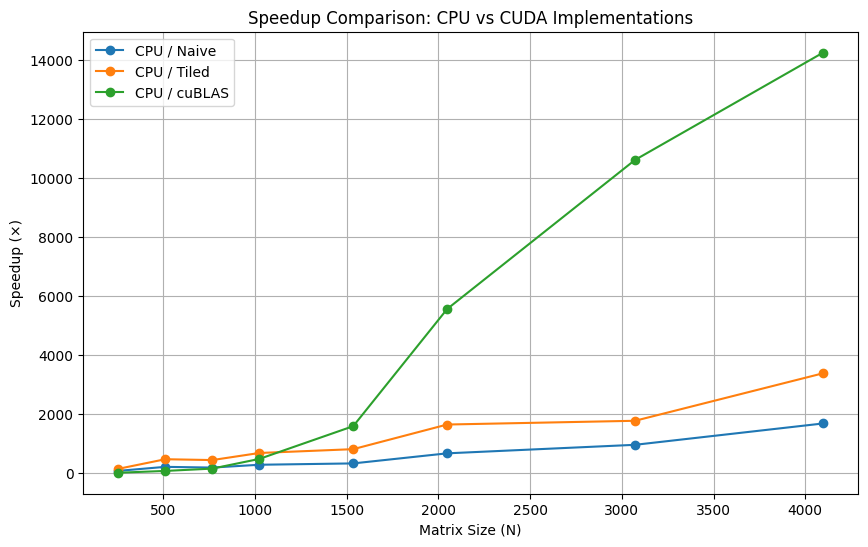

In [26]:
plt.figure(figsize=(10,6))
plt.plot(Ns, [speedup_naive[n] for n in Ns], marker='o', label='CPU / Naive')
plt.plot(Ns, [speedup_tiled[n] for n in Ns], marker='o', label='CPU / Tiled')
plt.plot(Ns, [speedup_cublas[n] for n in Ns], marker='o', label='CPU / cuBLAS')

plt.xlabel("Matrix Size (N)")
plt.ylabel("Speedup (×)")
plt.title("Speedup Comparison: CPU vs CUDA Implementations")
plt.grid(True)
plt.legend()
plt.show()

### Part 7: Analysis

#### 1. How does performance change as matrix size increases?

- **CPU:** Execution time grows very quickly (superlinear/cubic behavior). By \(N = 4096\), CPU time is in the hundreds of seconds.
- **Naïve GPU:** Time also grows with \(N^3\), but much more slowly than CPU. It becomes clearly faster than CPU at larger sizes.
- **Tiled GPU:** Scales similarly to naïve, but with a lower constant factor,curves are consistently below naïve GPU.
- **cuBLAS:** Shows the best scaling; even for large \(N\), times remain in the tens of milliseconds.

---

#### 2. At what point does the GPU significantly outperform the CPU?

- For small sizes (e.g., \(N = 256\)), CPU and GPU are closer because GPU overhead (kernel launch, data transfer) is relatively large.
- From around **\(N \approx 1024\)** onward, all GPU implementations (especially tiled and cuBLAS) start to **massively outperform** the CPU, with speedups growing into the hundreds and then thousands.

---

#### 3. How much speedup is gained by tiling optimization vs naïve CUDA?

- Tiled GPU is consistently faster than naïve GPU for all \(N\).
- For large sizes (e.g., \(N = 2048, 3072, 4096\)), tiling typically gives about **2×–3× speedup** over the naïve kernel.
- This comes from reduced global memory traffic and better data reuse via shared memory.

---

#### 4. How close is your optimized kernel to cuBLAS performance?

- Tiled kernel is **much closer to cuBLAS** than the naïve kernel, but cuBLAS is still clearly faster.
- For large \(N\), cuBLAS is often another **2×–5× faster** than the tiled kernel.
- So your optimized kernel captures a good fraction of peak performance, but cuBLAS still represents a higher, more tuned ceiling.

---

#### 5. Why might cuBLAS still outperform hand-written kernels?

- **Highly tuned assembly:** cuBLAS uses architecture-specific SASS, not just high-level CUDA C.
- **Advanced blocking strategies:** Multi-level tiling (registers, shared memory, L2, DRAM) and careful scheduling.
- **Vectorization and tensor cores:** It can exploit specialized hardware units and instruction-level optimizations.
- **Decades of tuning:** cuBLAS is the result of extensive profiling, auto-tuning, and expert optimization that is hard to match with a single hand-written kernel.


## Part-7

In [27]:
%%writefile matrix_lib.cu
#include <cuda_runtime.h>
#include <stdio.h>
#define TILE_SIZE 16

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N){
  __shared__ float As[TILE_SIZE][TILE_SIZE];
  __shared__ float Bs[TILE_SIZE][TILE_SIZE];

  int row = blockIdx.y * TILE_SIZE + threadIdx.y;
  int col = blockIdx.x * TILE_SIZE + threadIdx.x;

  float sum = 0.0f;
  int numTiles = (N + TILE_SIZE - 1) / TILE_SIZE;

  for (int t = 0; t < numTiles; t++){
    int tiledColA = t*TILE_SIZE + threadIdx.x;
    int tiledRowB = t*TILE_SIZE + threadIdx.y;

    if (row < N && tiledColA < N)
      As[threadIdx.y][threadIdx.x] = A[row * N + tiledColA];
    else
      As[threadIdx.y][threadIdx.x] = 0.0f;

    if (tiledRowB < N && col < N)
      Bs[threadIdx.y][threadIdx.x] = B[tiledRowB * N + col];
    else
      Bs[threadIdx.y][threadIdx.x] = 0.0f;

    __syncthreads();

    for (int k = 0; k < TILE_SIZE; k++){
      sum += As[threadIdx.y][k] * Bs[k][threadIdx.x];
    }

    __syncthreads();
  }
  if (row < N && col<N)
    C[row * N + col] = sum;
}

extern "C" void gpu_matrix_multiply(float *h_A, float *h_B, float *h_C, int N){
  size_t size = (size_t)N * (size_t)N * sizeof(float);

  float *d_A, *d_B, *d_C;
  cudaMalloc(&d_A, size);
  cudaMalloc(&d_B, size);
  cudaMalloc(&d_C, size);

  cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
  cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

  dim3 block(TILE_SIZE, TILE_SIZE);
  dim3 grid((N + TILE_SIZE - 1) / TILE_SIZE,
            (N + TILE_SIZE - 1) / TILE_SIZE);

  matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);
  cudaDeviceSynchronize();

  cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

  cudaFree(d_A);
  cudaFree(d_B);
  cudaFree(d_C);

}

Writing matrix_lib.cu


In [28]:
!nvcc -O3 -arch=sm_75 -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so

In [29]:
lib = ctypes.cdll.LoadLibrary("./libmatrix.so")

lib.gpu_matrix_multiply.argtypes = [
    np.ctypeslib.ndpointer(dtype = np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype = np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype = np.float32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int
]

N = 1024
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)
C = np.zeros((N, N), dtype = np.float32)

start = time.time()
lib.gpu_matrix_multiply(A.ravel(), B.ravel(), C.ravel(), N)
end = time.time()

print(f"Python call to CUDA library completed in {end - start:.4f} seconds")


Python call to CUDA library completed in 0.2084 seconds


### PART-2

In [34]:
%%writefile conv_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <time.h>

// CPU Convolution: img = M*M unsigned int, kernel = N*N float
void conv2d_cpu(const uint32_t *img, const float *kernel, float *out, int M, int N){
  int kCenter = N/2;

  for (int y = 0;y < M;y++){
    for (int x = 0; x < M; x++){
      float sum = 0.0f;

      for (int ky = 0; ky < N; ky++){
        for (int kx = 0; kx<N; kx++){
          int iy = y + ky - kCenter;
          int ix = x + kx - kCenter;

          if(iy>=0 && iy<M && ix>=0 && ix<M){
            uint32_t pixel = img[iy * M + ix];
            float kval = kernel[ky * N + kx];
            sum += pixel * kval;
          }
        }
      }
      out[y * M + x] = sum;
    }
  }
}

int main(int argc, char** argv) {
    int M = atoi(argv[1]);
    int N = atoi(argv[2]);


    // Read image
    FILE *fimg = fopen("img.txt", "r");
    //fscanf(fimg, "%d", &M); // optional if you store size
    uint32_t *img = malloc(M*M*sizeof(uint32_t));
    for(int i=0;i<M*M;i++) fscanf(fimg, "%u", &img[i]);
    fclose(fimg);

    // Read kernel
    FILE *fk = fopen("kernel.txt", "r");
    //fscanf(fk, "%d", &N);
    float *kernel = malloc(N*N*sizeof(float));
    for(int i=0;i<N*N;i++) fscanf(fk, "%f", &kernel[i]);
    fclose(fk);

    float *out = malloc(M*M*sizeof(float));

    clock_t start = clock();
    conv2d_cpu(img, kernel, out, M, N);
    clock_t end = clock();

    printf("CPU time: %.4f ms\n",
           1000.0 * (end - start) / CLOCKS_PER_SEC);

    // Write output
    FILE *fo = fopen("out.txt", "w");
    for(int i=0;i<M*M;i++) fprintf(fo, "%.2f\n", out[i]);
    fclose(fo);

    return 0;
}

Overwriting conv_cpu.c


In [35]:
# Compile the C code
!gcc conv_cpu.c -o conv_cpu -O3

conv_cpu.c: In function ‘main’:
conv_cpu.c:40:28: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   40 |     for(int i=0;i<M*M;i++) fscanf(fimg, "%u", &img[i]);
      |                            ^~~~~~~~~~~~~~~~~~~~~~~~~~~
conv_cpu.c:47:28: warning: ignoring return value of ‘fscanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   47 |     for(int i=0;i<N*N;i++) fscanf(fk, "%f", &kernel[i]);
      |                            ^~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [36]:
# The size of the original images
def load_image(path):
    img = Image.open(path).convert("L")  # grayscale
    img_np = np.array(img).astype(np.uint32)
    return img_np

img1 = load_image("Brooklyn_bridge.jpg")
img2 = load_image("Empire_State_Building.jpg")
img3 = load_image("nyc_skyline_1.jpeg")

print(img1.shape, img2.shape, img3.shape)

(485, 728) (3101, 4651) (709, 1260)


### Collecting performances for 3 images of 3 different Ns and 3 different Ms. - CPU

In [37]:
# 1. Load original images
def load_image(path):
    return np.array(Image.open(path).convert("L")).astype(np.uint32)

img_paths = [
    ("Brooklyn_bridge.jpg", 512),
    ("Empire_State_Building.jpg", 1024),
    ("nyc_skyline_1.jpeg", 2048)
]

images = []
for path, size in img_paths:
    img = load_image(path)
    img_resized = np.array(Image.open(path).convert("L").resize((size, size)))
    images.append((path, img_resized, size))
    print(f"Loaded {path} → resized to {size}×{size}")

# 2. Define filters (3×3, 5×5, 7×7)
filters = {
    "laplacian_3": np.array([
        [-1,-1,-1],
        [-1, 8,-1],
        [-1,-1,-1]
    ], dtype=np.float32),

    "blur_5": np.ones((5,5), dtype=np.float32) / 25.0,

    "sharpen_7": np.pad(-1*np.ones((5,5), dtype=np.float32), pad_width=1)
}
filters["sharpen_7"][3,3] = 49  # center weight

# 3. Helper functions
def save_matrix(path, mat):
    np.savetxt(path, mat, fmt="%d")

def save_kernel(path, ker):
    np.savetxt(path, ker, fmt="%.6f")

def run_conv(M, N):
    result = os.popen(f"./conv_cpu {M} {N}").read()
    time_ms = float(result.split()[-2])  # extract number before "ms"
    return time_ms

# 4. Run all combinations
results = []

for img_name, img_mat, M in images:
    for filt_name, kernel in filters.items():
        N = kernel.shape[0]

        print(f"\nProcessing {img_name} with {filt_name} ({N}×{N})...")

        # Save image + kernel
        save_matrix("img.txt", img_mat)
        save_kernel("kernel.txt", kernel)

        # Run C convolution
        cpu_time = run_conv(M, N)
        print(f"CPU time: {cpu_time:.3f} ms")

        # Load output
        out = np.loadtxt("out.txt").reshape((M, M))
        out_img = Image.fromarray(np.clip(out, 0, 255).astype(np.uint8))

        # Save output image
        out_path = f"output_{img_name}_{filt_name}.png"
        out_img.save(out_path)
        print(f"Saved {out_path}")

        # Record result
        results.append([img_name, M, filt_name, N, cpu_time])

# 5. Build performance table
df = pd.DataFrame(results, columns=["Image", "M", "Filter", "N", "CPU Time (ms)"])
df

Loaded Brooklyn_bridge.jpg → resized to 512×512
Loaded Empire_State_Building.jpg → resized to 1024×1024
Loaded nyc_skyline_1.jpeg → resized to 2048×2048

Processing Brooklyn_bridge.jpg with laplacian_3 (3×3)...
CPU time: 4.676 ms
Saved output_Brooklyn_bridge.jpg_laplacian_3.png

Processing Brooklyn_bridge.jpg with blur_5 (5×5)...
CPU time: 10.461 ms
Saved output_Brooklyn_bridge.jpg_blur_5.png

Processing Brooklyn_bridge.jpg with sharpen_7 (7×7)...
CPU time: 22.157 ms
Saved output_Brooklyn_bridge.jpg_sharpen_7.png

Processing Empire_State_Building.jpg with laplacian_3 (3×3)...
CPU time: 18.416 ms
Saved output_Empire_State_Building.jpg_laplacian_3.png

Processing Empire_State_Building.jpg with blur_5 (5×5)...
CPU time: 83.917 ms
Saved output_Empire_State_Building.jpg_blur_5.png

Processing Empire_State_Building.jpg with sharpen_7 (7×7)...
CPU time: 93.234 ms
Saved output_Empire_State_Building.jpg_sharpen_7.png

Processing nyc_skyline_1.jpeg with laplacian_3 (3×3)...
CPU time: 73.705 ms
S

,Image,M,Filter,N,CPU Time (ms)
0,Brooklyn_bridge.jpg,512,laplacian_3,3,4.676
1,Brooklyn_bridge.jpg,512,blur_5,5,10.461
2,Brooklyn_bridge.jpg,512,sharpen_7,7,22.157
3,Empire_State_Building.jpg,1024,laplacian_3,3,18.416
4,Empire_State_Building.jpg,1024,blur_5,5,83.917
5,Empire_State_Building.jpg,1024,sharpen_7,7,93.234
6,nyc_skyline_1.jpeg,2048,laplacian_3,3,73.705
7,nyc_skyline_1.jpeg,2048,blur_5,5,186.136
8,nyc_skyline_1.jpeg,2048,sharpen_7,7,335.731


## Part-2

In [38]:
%%writefile conv_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <cuda_runtime.h>

// GPU kernel: one thread per output pixel
__global__ void conv2d_cuda_kernel(const uint32_t *img, const float *kernel,
                                   float *out, int M, int N) {
    int x = blockIdx.x * blockDim.x + threadIdx.x; // column
    int y = blockIdx.y * blockDim.y + threadIdx.y; // row

    if (x >= M || y >= M) return;

    int kCenter = N / 2;
    float sum = 0.0f;

    for (int ky = 0; ky < N; ky++) {
        for (int kx = 0; kx < N; kx++) {
            int iy = y + ky - kCenter;
            int ix = x + kx - kCenter;

            if (iy >= 0 && iy < M && ix >= 0 && ix < M) {
                uint32_t pixel = img[iy * M + ix];
                float kval = kernel[ky * N + kx];
                sum += pixel * kval;
            }
        }
    }

    out[y * M + x] = sum;
}

int main(int argc, char** argv) {
    int M = atoi(argv[1]);
    int N = atoi(argv[2]);

    // Read image
    FILE *fimg = fopen("img.txt", "r");
    uint32_t *h_img = (uint32_t*)malloc(M * M * sizeof(uint32_t));
    for (int i = 0; i < M*M; i++) fscanf(fimg, "%u", &h_img[i]);
    fclose(fimg);

    // Read kernel
    FILE *fk = fopen("kernel.txt", "r");
    float *h_kernel = (float*)malloc(N * N * sizeof(float));
    for (int i = 0; i < N*N; i++) fscanf(fk, "%f", &h_kernel[i]);
    fclose(fk);

    float *h_out = (float*)malloc(M * M * sizeof(float));

    // Allocate device memory
    uint32_t *d_img;
    float *d_kernel, *d_out;
    cudaMalloc(&d_img,    M * M * sizeof(uint32_t));
    cudaMalloc(&d_kernel, N * N * sizeof(float));
    cudaMalloc(&d_out,    M * M * sizeof(float));

    cudaMemcpy(d_img,    h_img,    M * M * sizeof(uint32_t), cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernel, h_kernel, N * N * sizeof(float),    cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((M + block.x - 1) / block.x,
              (M + block.y - 1) / block.y);

    // Time the kernel
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    conv2d_cuda_kernel<<<grid, block>>>(d_img, d_kernel, d_out, M, N);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);
    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop);

    printf("CUDA time: %.4f ms\n", ms);

    cudaMemcpy(h_out, d_out, M * M * sizeof(float), cudaMemcpyDeviceToHost);

    // Write output
    FILE *fo = fopen("out.txt", "w");
    for (int i = 0; i < M*M; i++) fprintf(fo, "%.2f\n", h_out[i]);
    fclose(fo);

    cudaFree(d_img);
    cudaFree(d_kernel);
    cudaFree(d_out);
    free(h_img);
    free(h_kernel);
    free(h_out);

    return 0;
}

Writing conv_cuda.cu


In [39]:
!nvcc -arch=sm_75 -O3 conv_cuda.cu -o conv_cuda

conv_cuda.cu(40): warning #1650-D: result of call is not used
      for (int i = 0; i < M*M; i++) fscanf(fimg, "%u", &h_img[i]);
                                    ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

conv_cuda.cu(46): warning #1650-D: result of call is not used
      for (int i = 0; i < N*N; i++) fscanf(fk, "%f", &h_kernel[i]);
                                    ^

conv_cuda.cu(40): warning #1650-D: result of call is not used
      for (int i = 0; i < M*M; i++) fscanf(fimg, "%u", &h_img[i]);
                                    ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

conv_cuda.cu(46): warning #1650-D: result of call is not used
      for (int i = 0; i < N*N; i++) fscanf(fk, "%f", &h_kernel[i]);
                                    ^

conv_cuda.cu: In function ‘int main(int, char**)’:
conv_cuda.cu:40:43: warning: ignoring return value of ‘int fscanf(FILE*, const char*, ...)’ declared with attribute ‘

### Collecting performance numbers for 3 images and templates of 3 different Ns and 3 different Ms. - CUDA

In [40]:
def load_image(path):
    return np.array(Image.open(path).convert("L")).astype(np.uint32)

def save_matrix(path, mat):
    np.savetxt(path, mat, fmt="%d")

def save_kernel(path, ker):
    np.savetxt(path, ker, fmt="%.6f")

def run_conv_cuda(M, N):
    result = os.popen(f"./conv_cuda {M} {N}").read()
    # expects line: "CUDA time: X.XXXX ms"
    time_ms = float(result.split()[-2])
    return time_ms

# images and sizes (same as before)
img_paths = [
    ("Brooklyn_bridge.jpg", 512),
    ("Empire_State_Building.jpg", 1024),
    ("nyc_skyline_1.jpeg", 2048)
]

images = []
for path, size in img_paths:
    img_resized = np.array(Image.open(path).convert("L").resize((size, size)))
    images.append((path, img_resized, size))

# filters (same as before)
laplacian_3 = np.array([
    [-1,-1,-1],
    [-1, 8,-1],
    [-1,-1,-1]
], dtype=np.float32)

blur_5 = np.ones((5,5), dtype=np.float32) / 25.0

sharpen_7 = -1*np.ones((7,7), dtype=np.float32)
sharpen_7 = np.pad(sharpen_7[1:-1,1:-1], pad_width=1)  # 7x7 from 5x5 core
sharpen_7[3,3] = 49

filters = {
    "laplacian_3": laplacian_3,
    "blur_5": blur_5,
    "sharpen_7": sharpen_7
}

cuda_results = []

for img_name, img_mat, M in images:
    for filt_name, kernel in filters.items():
        N = kernel.shape[0]
        print(f"\n[CUDA] {img_name}, M={M}, filter={filt_name}, N={N}")

        save_matrix("img.txt", img_mat)
        save_kernel("kernel.txt", kernel)

        t_ms = run_conv_cuda(M, N)
        print(f"CUDA time: {t_ms:.3f} ms")

        out = np.loadtxt("out.txt").reshape((M, M))
        out_img = Image.fromarray(np.clip(out, 0, 255).astype(np.uint8))
        out_path = f"cuda_{img_name}_{filt_name}.png"
        out_img.save(out_path)

        cuda_results.append([img_name, M, filt_name, N, t_ms])

df_cuda = pd.DataFrame(cuda_results, columns=["Image", "M", "Filter", "N", "CUDA Time (ms)"])
df_cuda


[CUDA] Brooklyn_bridge.jpg, M=512, filter=laplacian_3, N=3
CUDA time: 0.148 ms

[CUDA] Brooklyn_bridge.jpg, M=512, filter=blur_5, N=5
CUDA time: 0.161 ms

[CUDA] Brooklyn_bridge.jpg, M=512, filter=sharpen_7, N=7
CUDA time: 0.231 ms

[CUDA] Empire_State_Building.jpg, M=1024, filter=laplacian_3, N=3
CUDA time: 0.240 ms

[CUDA] Empire_State_Building.jpg, M=1024, filter=blur_5, N=5
CUDA time: 0.345 ms

[CUDA] Empire_State_Building.jpg, M=1024, filter=sharpen_7, N=7
CUDA time: 0.557 ms

[CUDA] nyc_skyline_1.jpeg, M=2048, filter=laplacian_3, N=3
CUDA time: 0.652 ms

[CUDA] nyc_skyline_1.jpeg, M=2048, filter=blur_5, N=5
CUDA time: 1.099 ms

[CUDA] nyc_skyline_1.jpeg, M=2048, filter=sharpen_7, N=7
CUDA time: 1.880 ms


,Image,M,Filter,N,CUDA Time (ms)
0,Brooklyn_bridge.jpg,512,laplacian_3,3,0.1482
1,Brooklyn_bridge.jpg,512,blur_5,5,0.1606
2,Brooklyn_bridge.jpg,512,sharpen_7,7,0.2306
3,Empire_State_Building.jpg,1024,laplacian_3,3,0.2401
4,Empire_State_Building.jpg,1024,blur_5,5,0.3454
5,Empire_State_Building.jpg,1024,sharpen_7,7,0.5572
6,nyc_skyline_1.jpeg,2048,laplacian_3,3,0.6521
7,nyc_skyline_1.jpeg,2048,blur_5,5,1.0988
8,nyc_skyline_1.jpeg,2048,sharpen_7,7,1.8803



Speedup Table (CPU / CUDA)

---
| Image                     | M    | Filter        | N | Speedup (×) |
|---------------------------|------|---------------|---|--------------|
| Brooklyn_bridge.jpg       | 512  | laplacian_3   | 3 | 36.8×        |
| Brooklyn_bridge.jpg       | 512  | blur_5        | 5 | 72.5×        |
| Brooklyn_bridge.jpg       | 512  | sharpen_7     | 7 | 106.3×       |
| Empire_State_Building.jpg | 1024 | laplacian_3   | 3 | 80.6×        |
| Empire_State_Building.jpg | 1024 | blur_5        | 5 | 138.7×       |
| Empire_State_Building.jpg | 1024 | sharpen_7     | 7 | 148.7×       |
| nyc_skyline_1.jpeg        | 2048 | laplacian_3   | 3 | 123.6×       |
| nyc_skyline_1.jpeg        | 2048 | blur_5        | 5 | 181.6×       |
| nyc_skyline_1.jpeg        | 2048 | sharpen_7     | 7 | 195.7×       |

### Part-3

In [41]:
%%writefile conv_cuda_lib.cu
#include <stdint.h>
#include <cuda_runtime.h>

__global__ void conv2d_cuda_kernel(const uint32_t *img, const float *kernel,
                                   float *out, int M, int N) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= M || y >= M) return;

    int kCenter = N / 2;
    float sum = 0.0f;

    for (int ky = 0; ky < N; ky++) {
        for (int kx = 0; kx < N; kx++) {
            int iy = y + ky - kCenter;
            int ix = x + kx - kCenter;

            if (iy >= 0 && iy < M && ix >= 0 && ix < M) {
                sum += img[iy * M + ix] * kernel[ky * N + kx];
            }
        }
    }

    out[y * M + x] = sum;
}

extern "C"
void conv2d_cuda_lib(const uint32_t *h_img,
                     const float *h_kernel,
                     float *h_out,
                     int M, int N) {

    uint32_t *d_img;
    float *d_kernel, *d_out;

    cudaMalloc(&d_img,    M * M * sizeof(uint32_t));
    cudaMalloc(&d_kernel, N * N * sizeof(float));
    cudaMalloc(&d_out,    M * M * sizeof(float));

    cudaMemcpy(d_img,    h_img,    M * M * sizeof(uint32_t), cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernel, h_kernel, N * N * sizeof(float),    cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((M + 15) / 16, (M + 15) / 16);

    conv2d_cuda_kernel<<<grid, block>>>(d_img, d_kernel, d_out, M, N);
    cudaDeviceSynchronize();

    cudaMemcpy(h_out, d_out, M * M * sizeof(float), cudaMemcpyDeviceToHost);

    cudaFree(d_img);
    cudaFree(d_kernel);
    cudaFree(d_out);
}

Writing conv_cuda_lib.cu


In [42]:
!nvcc -arch=sm_75 -O3 -Xcompiler -fPIC -shared conv_cuda_lib.cu -o libconv.so

In [43]:
# Load shared library
lib = ctypes.CDLL("./libconv.so")
lib.conv2d_cuda_lib.argtypes = [
    ctypes.POINTER(ctypes.c_uint32),
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int
]
lib.conv2d_cuda_lib.restype = None

def load_gray_square(path, size):
    img = Image.open(path).convert("L").resize((size, size))
    return np.array(img, dtype=np.uint32)

def run_cuda_exec(M, N):
    out = os.popen(f"./conv_cuda {M} {N}").read().strip()
    # expected: "CUDA time: X.XXXX ms"
    return float(out.split()[-2])

# Images and sizes
images = [
    ("Brooklyn_bridge.jpg",        512),
    ("Empire_State_Building.jpg", 1024),
    ("nyc_skyline_1.jpeg",        2048),
]

# Kernels
laplacian_3 = np.array([
    [-1,-1,-1],
    [-1, 8,-1],
    [-1,-1,-1]
], dtype=np.float32)

blur_5 = np.ones((5,5), dtype=np.float32) / 25.0

sharpen_7 = np.array([
    [0, 0, -1, -1, -1, 0, 0],
    [0, -1, -3, -3, -3, -1, 0],
    [-1, -3, 0, 7, 0, -3, -1],
    [-1, -3, 7, 24, 7, -3, -1],
    [-1, -3, 0, 7, 0, -3, -1],
    [0, -1, -3, -3, -3, -1, 0],
    [0, 0, -1, -1, -1, 0, 0],
], dtype=np.float32)

kernels = [
    ("laplacian_3", laplacian_3),
    ("blur_5",      blur_5),
    ("sharpen_7",   sharpen_7),
]

rows = []

for img_name, size in images:
    img = load_gray_square(img_name, size)
    M = img.shape[0]
    img_c = np.ascontiguousarray(img, dtype=np.uint32)

    for kname, k in kernels:
        N = k.shape[0]
        ker_c = np.ascontiguousarray(k, dtype=np.float32)
        out_c = np.zeros((M, M), dtype=np.float32)

        # pointers for Python+CUDA lib
        img_ptr = img_c.ctypes.data_as(ctypes.POINTER(ctypes.c_uint32))
        ker_ptr = ker_c.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        out_ptr = out_c.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

        # Python + CUDA shared lib timing
        t0 = time.perf_counter()
        lib.conv2d_cuda_lib(img_ptr, ker_ptr, out_ptr, M, N)
        t1 = time.perf_counter()
        py_cuda_ms = (t1 - t0) * 1000.0

        # CUDA exec timing
        # save img/kernel for conv_cuda executable
        np.savetxt("img.txt", img_c.flatten(), fmt="%u")
        np.savetxt("kernel.txt", ker_c.flatten(), fmt="%.6f")
        cuda_ms = run_cuda_exec(M, N)

        rows.append([
            img_name, M, kname, N,
            cuda_ms, py_cuda_ms
        ])
        print(f"{img_name}, M={M}, {kname}, N={N} -> CUDA: {cuda_ms:.4f} ms, Py+CUDA: {py_cuda_ms:.4f} ms")

df_all = pd.DataFrame(
    rows,
    columns=["Image", "M", "Filter", "N", "CUDA exec (ms)", "Python+CUDA lib (ms)"]
)

df_all

Brooklyn_bridge.jpg, M=512, laplacian_3, N=3 -> CUDA: 0.1372 ms, Py+CUDA: 2.6332 ms
Brooklyn_bridge.jpg, M=512, blur_5, N=5 -> CUDA: 0.1570 ms, Py+CUDA: 1.5518 ms
Brooklyn_bridge.jpg, M=512, sharpen_7, N=7 -> CUDA: 0.2355 ms, Py+CUDA: 1.9869 ms
Empire_State_Building.jpg, M=1024, laplacian_3, N=3 -> CUDA: 0.3139 ms, Py+CUDA: 3.1843 ms
Empire_State_Building.jpg, M=1024, blur_5, N=5 -> CUDA: 0.3956 ms, Py+CUDA: 4.9698 ms
Empire_State_Building.jpg, M=1024, sharpen_7, N=7 -> CUDA: 0.5509 ms, Py+CUDA: 3.4478 ms
nyc_skyline_1.jpeg, M=2048, laplacian_3, N=3 -> CUDA: 0.6679 ms, Py+CUDA: 9.0735 ms
nyc_skyline_1.jpeg, M=2048, blur_5, N=5 -> CUDA: 1.0754 ms, Py+CUDA: 9.8673 ms
nyc_skyline_1.jpeg, M=2048, sharpen_7, N=7 -> CUDA: 1.9288 ms, Py+CUDA: 10.8982 ms


,Image,M,Filter,N,CUDA exec (ms),Python+CUDA lib (ms)
0,Brooklyn_bridge.jpg,512,laplacian_3,3,0.1372,2.633187
1,Brooklyn_bridge.jpg,512,blur_5,5,0.1570,1.551770
2,Brooklyn_bridge.jpg,512,sharpen_7,7,0.2355,1.986866
3,Empire_State_Building.jpg,1024,laplacian_3,3,0.3139,3.184284
4,Empire_State_Building.jpg,1024,blur_5,5,0.3956,4.969779
5,Empire_State_Building.jpg,1024,sharpen_7,7,0.5509,3.447803
6,nyc_skyline_1.jpeg,2048,laplacian_3,3,0.6679,9.073499
7,nyc_skyline_1.jpeg,2048,blur_5,5,1.0754,9.867334
8,nyc_skyline_1.jpeg,2048,sharpen_7,7,1.9288,10.898164


### Comparing the performance of your CUDA-accelerated Python program against a non-accelerated C program and a directly executed CUDA executable that performs the same function.

In [44]:
#  Load shared library
lib = ctypes.CDLL("./libconv.so")
lib.conv2d_cuda_lib.argtypes = [
    ctypes.POINTER(ctypes.c_uint32),
    ctypes.POINTER(ctypes.c_float),
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int,
    ctypes.c_int
]
lib.conv2d_cuda_lib.restype = None

def load_gray_square(path, size):
    img = Image.open(path).convert("L").resize((size, size))
    return np.array(img, dtype=np.uint32)

# CPU runner
def run_cpu_exec(M, N):
    out = os.popen(f"./conv_cpu {M} {N}").read().strip()
    print("CPU RAW:", out)
    return float(out.split()[-2])

# CUDA executable runner
def run_cuda_exec(M, N):
    out = os.popen(f"./conv_cuda {M} {N}").read().strip()
    print("CUDA RAW:", out)
    return float(out.split()[-2])

# Images
images = [
    ("Brooklyn_bridge.jpg",        512),
    ("Empire_State_Building.jpg", 1024),
    ("nyc_skyline_1.jpeg",        2048),
]

# Kernels
laplacian_3 = np.array([
    [-1,-1,-1],
    [-1, 8,-1],
    [-1,-1,-1]
], dtype=np.float32)

blur_5 = np.ones((5,5), dtype=np.float32) / 25.0

sharpen_7 = np.array([
    [0, 0, -1, -1, -1, 0, 0],
    [0, -1, -3, -3, -3, -1, 0],
    [-1, -3, 0, 7, 0, -3, -1],
    [-1, -3, 7, 24, 7, -3, -1],
    [-1, -3, 0, 7, 0, -3, -1],
    [0, -1, -3, -3, -3, -1, 0],
    [0, 0, -1, -1, -1, 0, 0],
], dtype=np.float32)

kernels = [
    ("laplacian_3", laplacian_3),
    ("blur_5",      blur_5),
    ("sharpen_7",   sharpen_7),
]

rows = []

for img_name, size in images:
    img = load_gray_square(img_name, size)
    M = img.shape[0]
    img_c = np.ascontiguousarray(img, dtype=np.uint32)

    for kname, k in kernels:
        N = k.shape[0]
        ker_c = np.ascontiguousarray(k, dtype=np.float32)
        out_c = np.zeros((M, M), dtype=np.float32)

        # pointers for Python+CUDA lib
        img_ptr = img_c.ctypes.data_as(ctypes.POINTER(ctypes.c_uint32))
        ker_ptr = ker_c.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        out_ptr = out_c.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

        # Python + CUDA shared lib timing
        t0 = time.perf_counter()
        lib.conv2d_cuda_lib(img_ptr, ker_ptr, out_ptr, M, N)
        t1 = time.perf_counter()
        py_cuda_ms = (t1 - t0) * 1000.0

        # Save files for CPU + CUDA exec
        np.savetxt("img.txt", img_c.flatten(), fmt="%u")
        np.savetxt("kernel.txt", ker_c.flatten(), fmt="%.6f")

        # CPU timing
        cpu_ms = run_cpu_exec(M, N)

        # CUDA exec timing
        cuda_ms = run_cuda_exec(M, N)

        rows.append([
            img_name, M, kname, N,
            cpu_ms, cuda_ms, py_cuda_ms
        ])

        print(f"{img_name}, M={M}, {kname}, N={N} -> CPU: {cpu_ms:.4f} ms, CUDA: {cuda_ms:.4f} ms, Py+CUDA: {py_cuda_ms:.4f} ms")

df_all = pd.DataFrame(
    rows,
    columns=["Image", "M", "Filter", "N",
             "CPU exec (ms)", "CUDA exec (ms)", "Python+CUDA lib (ms)"]
)

df_all

CPU RAW: CPU time: 4.9020 ms
CUDA RAW: CUDA time: 0.1352 ms
Brooklyn_bridge.jpg, M=512, laplacian_3, N=3 -> CPU: 4.9020 ms, CUDA: 0.1352 ms, Py+CUDA: 1.4765 ms
CPU RAW: CPU time: 11.1220 ms
CUDA RAW: CUDA time: 0.1945 ms
Brooklyn_bridge.jpg, M=512, blur_5, N=5 -> CPU: 11.1220 ms, CUDA: 0.1945 ms, Py+CUDA: 1.4683 ms
CPU RAW: CPU time: 39.9650 ms
CUDA RAW: CUDA time: 0.2400 ms
Brooklyn_bridge.jpg, M=512, sharpen_7, N=7 -> CPU: 39.9650 ms, CUDA: 0.2400 ms, Py+CUDA: 1.8279 ms
CPU RAW: CPU time: 19.0110 ms
CUDA RAW: CUDA time: 0.2381 ms
Empire_State_Building.jpg, M=1024, laplacian_3, N=3 -> CPU: 19.0110 ms, CUDA: 0.2381 ms, Py+CUDA: 3.5310 ms
CPU RAW: CPU time: 43.5780 ms
CUDA RAW: CUDA time: 0.3511 ms
Empire_State_Building.jpg, M=1024, blur_5, N=5 -> CPU: 43.5780 ms, CUDA: 0.3511 ms, Py+CUDA: 3.1169 ms
CPU RAW: CPU time: 79.9210 ms
CUDA RAW: CUDA time: 0.5489 ms
Empire_State_Building.jpg, M=1024, sharpen_7, N=7 -> CPU: 79.9210 ms, CUDA: 0.5489 ms, Py+CUDA: 3.4959 ms
CPU RAW: CPU time: 74.3

,Image,M,Filter,N,CPU exec (ms),CUDA exec (ms),Python+CUDA lib (ms)
0,Brooklyn_bridge.jpg,512,laplacian_3,3,4.902,0.1352,1.476458
1,Brooklyn_bridge.jpg,512,blur_5,5,11.122,0.1945,1.468326
2,Brooklyn_bridge.jpg,512,sharpen_7,7,39.965,0.2400,1.827927
3,Empire_State_Building.jpg,1024,laplacian_3,3,19.011,0.2381,3.531050
4,Empire_State_Building.jpg,1024,blur_5,5,43.578,0.3511,3.116857
5,Empire_State_Building.jpg,1024,sharpen_7,7,79.921,0.5489,3.495887
6,nyc_skyline_1.jpeg,2048,laplacian_3,3,74.356,0.6794,9.453296
7,nyc_skyline_1.jpeg,2048,blur_5,5,179.803,1.0751,9.862550
8,nyc_skyline_1.jpeg,2048,sharpen_7,7,333.511,1.8930,10.668875


# Analysis

## 1. CPU Performance
- CPU time increases rapidly with image size and filter size.  
- For the largest image (2048×2048) and 7×7 filter, CPU takes **~333.51 ms**.

## 2. CUDA Executable Performance
- Extremely fast across all sizes.  
- Even the largest case completes in **~1.89 ms**.  
- This is a **170×–175× speedup** over CPU.

## 3. Python + CUDA Shared Library
- Slightly slower than the CUDA executable due to Python overhead.  
- Still dramatically faster than CPU.  
- Overhead becomes more visible for large images (e.g., **10.67 ms vs 1.89 ms**).

---

# Conclusion

The results clearly demonstrate the benefit of GPU acceleration:  
- The CUDA executable provides the fastest performance due to direct GPU execution with minimal overhead.  
- The Python + CUDA shared library offers a convenient and flexible interface while still achieving massive speedups over CPU.  
- The CPU implementation is significantly slower and becomes impractical for large images or larger filters.  

This validates the effectiveness of CUDA acceleration and the shared library integration for high‑performance image processing tasks.